In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from openai import OpenAI
from sklearn.preprocessing import LabelEncoder

#### Dicionário de dados

* `customerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa
* `gender`: gênero (masculino e feminino)
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos
* `Partner`:  se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `tenure`:  meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico
* `MultipleLines`: assisnatura de mais de uma linha de telefone
* `InternetService`: assinatura de um provedor internet
* `OnlineSecurity`: assinatura adicional de segurança online
* `OnlineBackup`: assinatura adicional de backup online
* `DeviceProtection`: assinatura adicional de proteção no dispositivo
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo
* `StreamingMovies`: assinatura de streaming de filmes
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `Charges.Monthly`: total de todos os serviços do cliente por mês
* `Charges.Total`: total gasto pelo cliente

# Conclusões das Análises dos Gráficos de Distribuição da Etapa Anterior


## Distribuições Desiguais:

- Temos um número muito mais alto de contagens para Não Churn que Sim Churn
- Senioridade está desigual, poucos clientes idosos.
- Dependentes está desigual
- Acúmulo de Tempo de contrato nos valores mais baixos
- PhoneService
- Online Security
- Online Backup
- Device Protection
- TechSupport
- StreamingTV
- StreamingMovies
- Acúmulo de ChargesMonthly e Total nas faixas menores, o que faz sentido pro ChargesTotal já que temos um número de clientes com poucos meses de contrato. Mas ChargesMonthly indica que temos um grande número de clientes com ticket baixo.

## Distribuições Iguais:
- A distribuiçõa de Gênero está equivalente.
- Parceiros está igual.
- Linhas Múltiplas
- InternetService
- Contract
- Paperless Billing
- Payment Method

# Hipóteses Até agora

- Entre homens e mulheres não vemos um padrão maior de churn por gênero.
- Entre os idosos, vemos uma taxa de cancelamento muito alta.
- Clientes que não possuem parceiros tendem a cancelar em torno de 2x mais.
- Existem mais clientes sem dependentes, porém os clientes com dependentes possuem uma taxa de cancelamento significativamente menor.
- A contagem alta de Churns em clientes com poucos meses de contrato demonstra uma taxa de cancelamento alta para os primeiros meses de contratação.
- Existe um número muito superior de clientes com contratação de serviços telefônicos, porém a taxa de churn aparenta estar proporcionalmente igual.
- Temos mais clientes SEM múltiplas linhas, mas a taxa de churn para os que tem é significativamente maior.
- A taxa de cancelamento para clientes com serviço de internet por fibra ótica extremamente alta, beirando os 50%. O que indica possível problema com o tipo de serviço.
- Temos mais clientes sem segurança online e com maior taxa de cancelamento do que aqueles que TEM segurança online.
- Mais clientes sem backup online, com uma taxa de cancelamento ligeiramente menor para aqueles que possuem backup online.
- O mesmo acontece para os clientes que possuem proteção de dispositivos.
- Clientes com suporte técnico tem uma taxa de churn 2x menor.
- Clientes sem StreamingTV possuem taxa de cancelamento menor, indicando possível problema com o tipo de serviço.
- O mesmo acontece para clientes sem StreamingMovies.
- Clientes com contrato mês a mês tem um Churn muito alto, em torno de 40%.
- Clientes com faturamento digital cancelam muito mais.
- Clientes que pagam com cheque eletrônico cancelam em torno de 40%.
- Não parece haver um padrão de churn em relação ao preço mensal.
- Distribuições desiguais podem fazer ser necessário utilizar uma reamostragem dos dados para evitar enviesamento do modelo. Utilizar outras métricas além de Acurácia, como F1-score, Recall e ROC-AUC.

# Importando o DF novo

In [ ]:
df_manipulacao = pd.read_csv('df_manipulacao.csv', index_col='ID')
df_manipulacao.head()

,Cancelamento,Genero,Idoso_Senior,Parceiro,Dependentes,Tempo_De_Contrato,Servico_Telefone,Varias_Linhas,Servico_Internet,Seguranca_Online,...,Protecao_Dispositivo,Suporte_Tecnico,Streaming_Tv,Filmes_Streaming,Tipo_De_Contrato,Faturamento_Sem_Papel,Metodo_De_Pagamento,Cobrancas_Mensais,Cobrancas_Totais,Cobrancas_Diarias
ID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46
0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27
0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80


# Refazendo as Distribuições dos Dados

<ipython-input-13-44b6a751abb0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


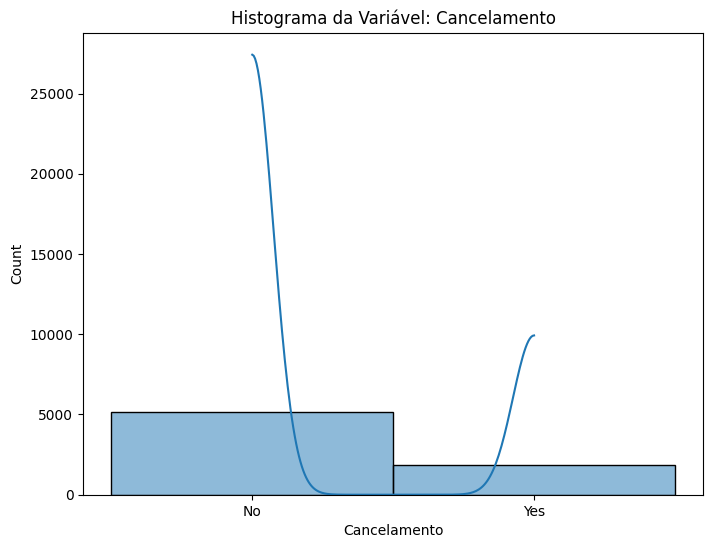

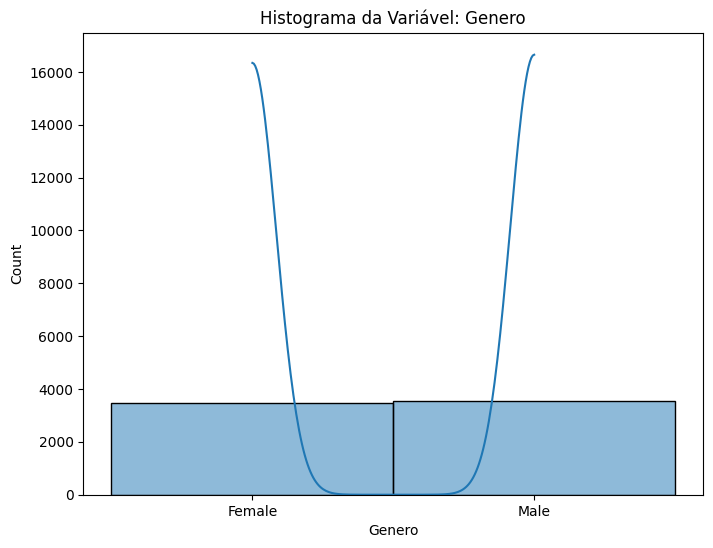

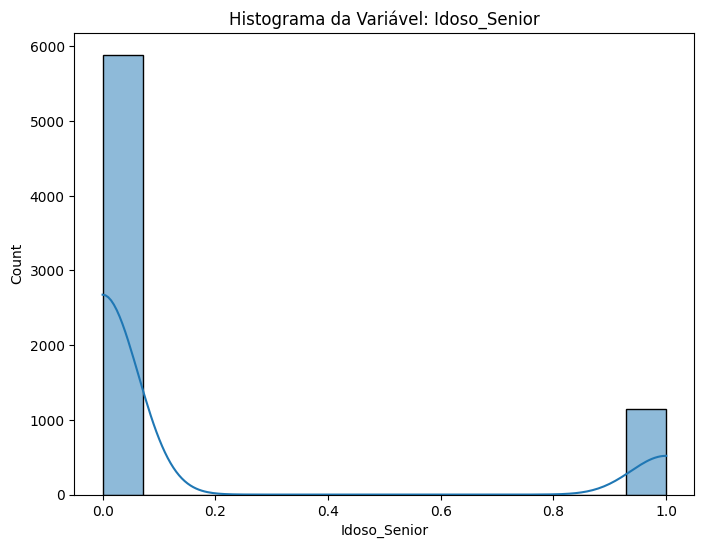

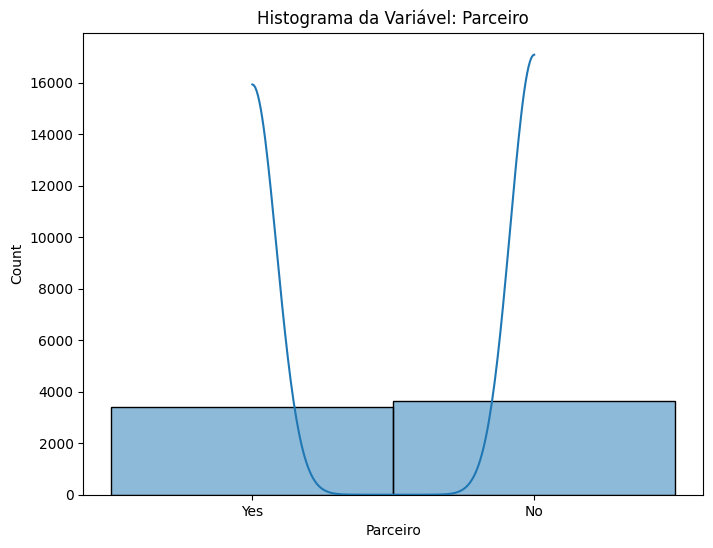

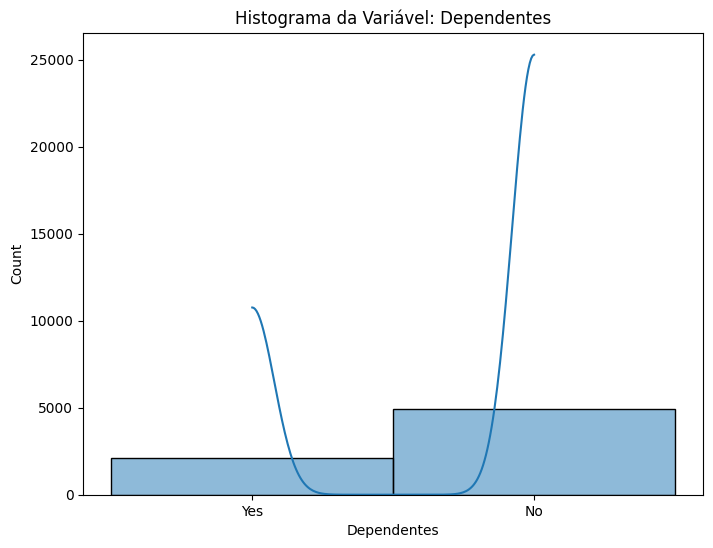

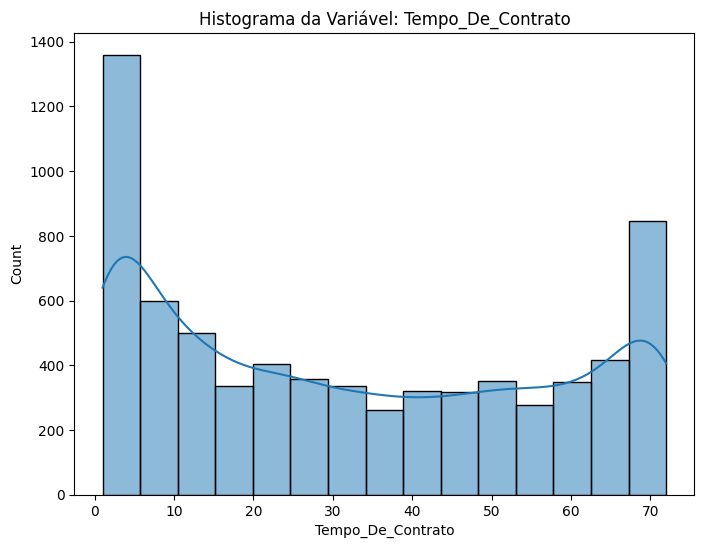

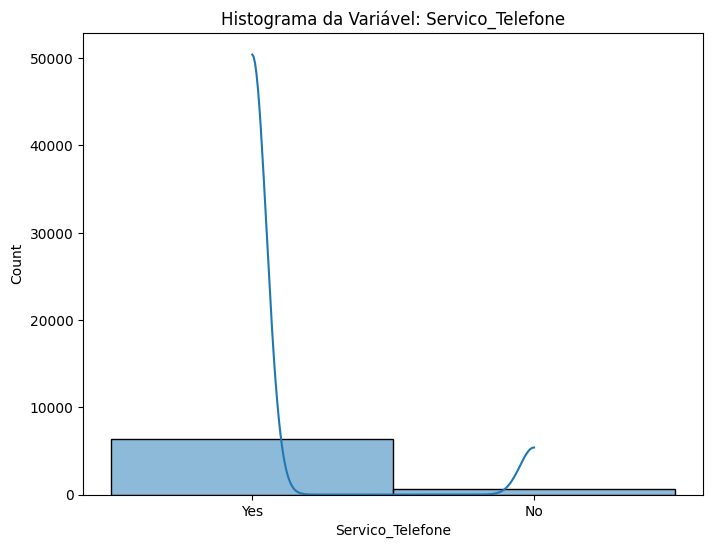

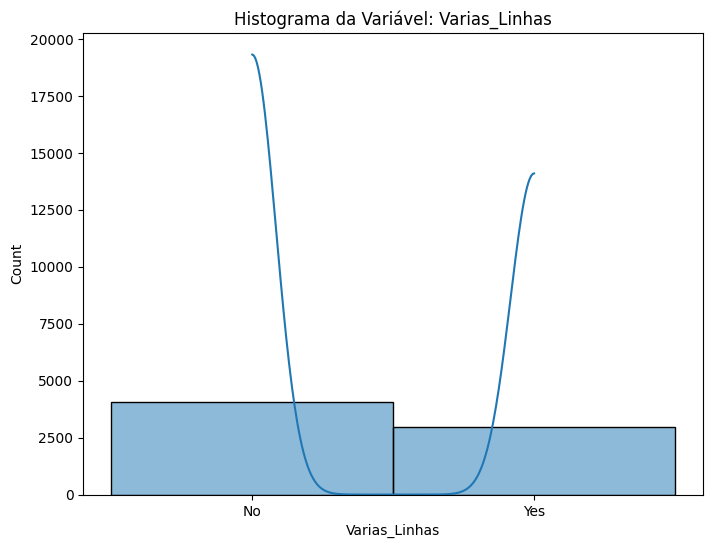

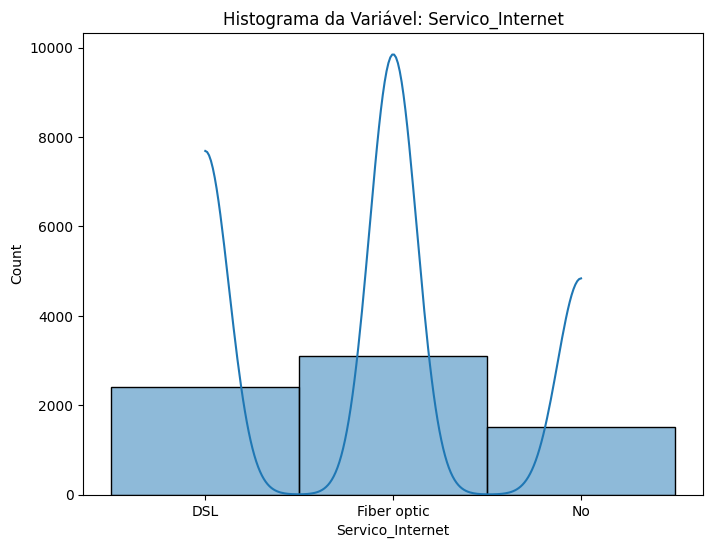

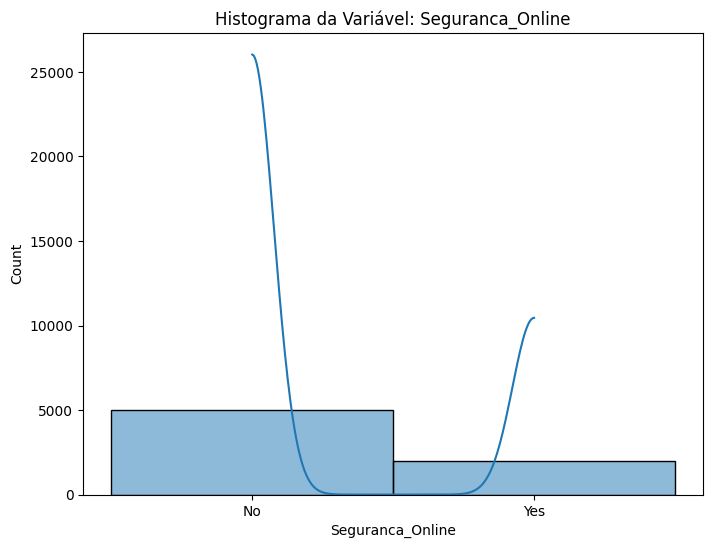

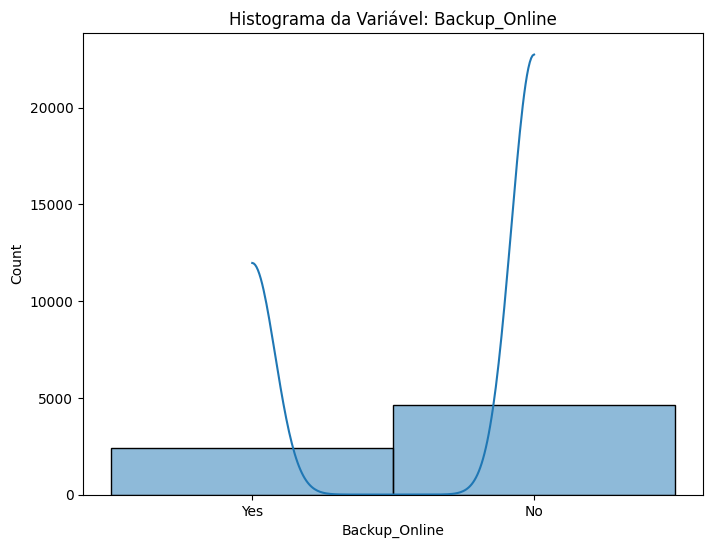

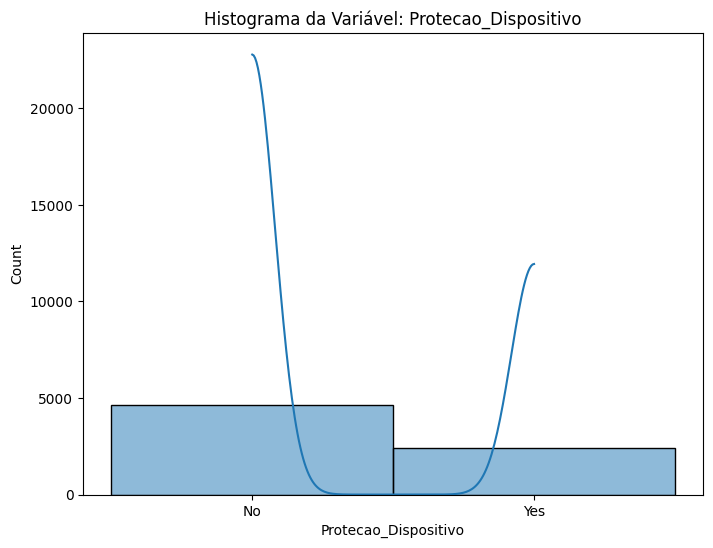

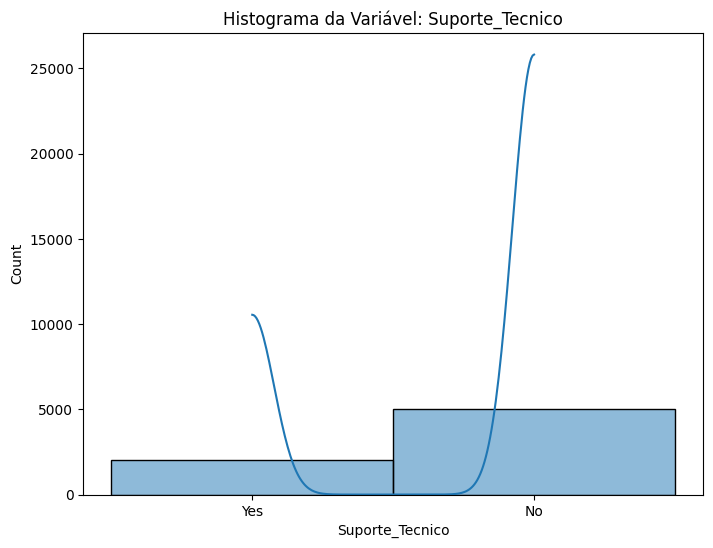

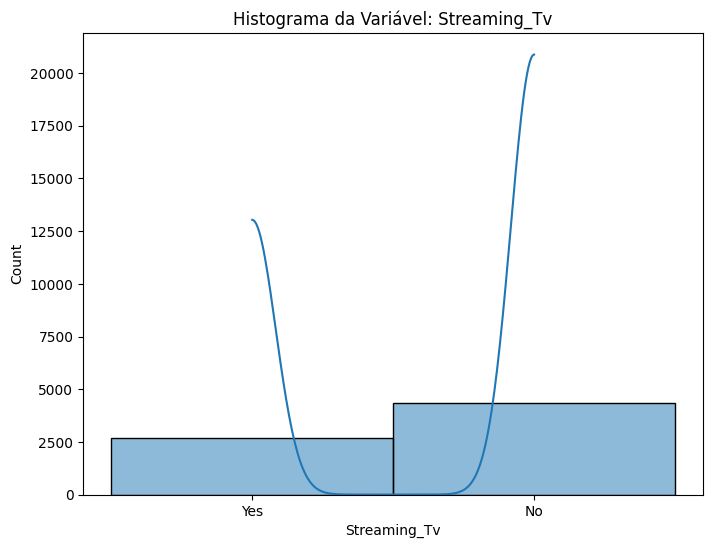

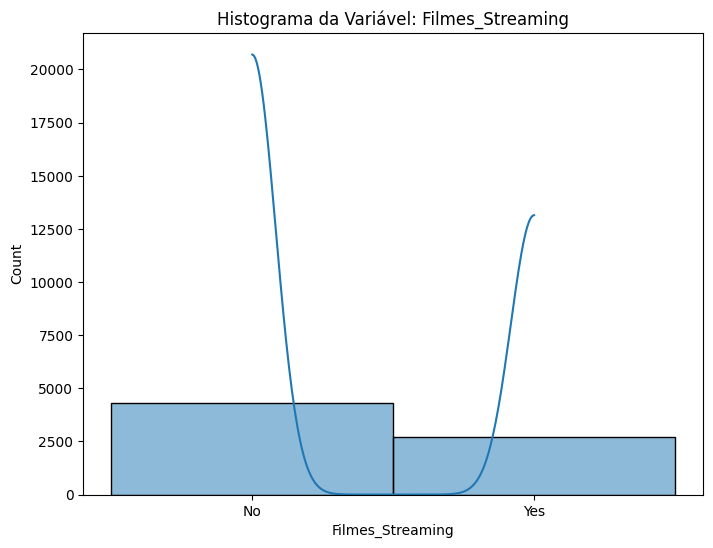

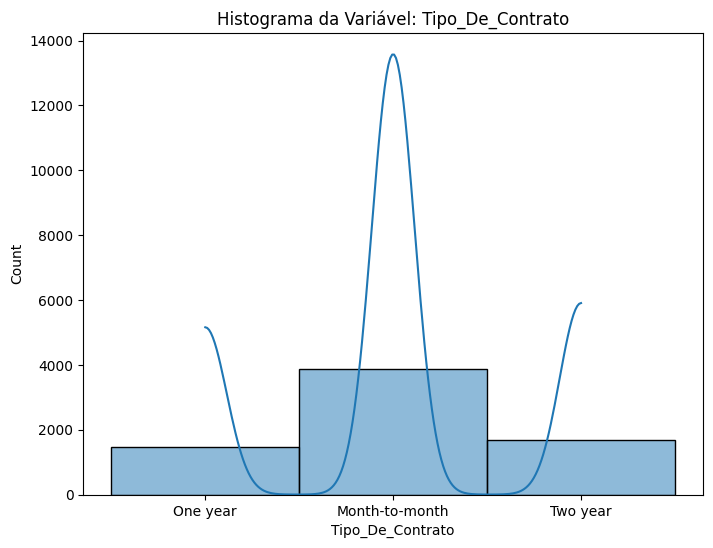

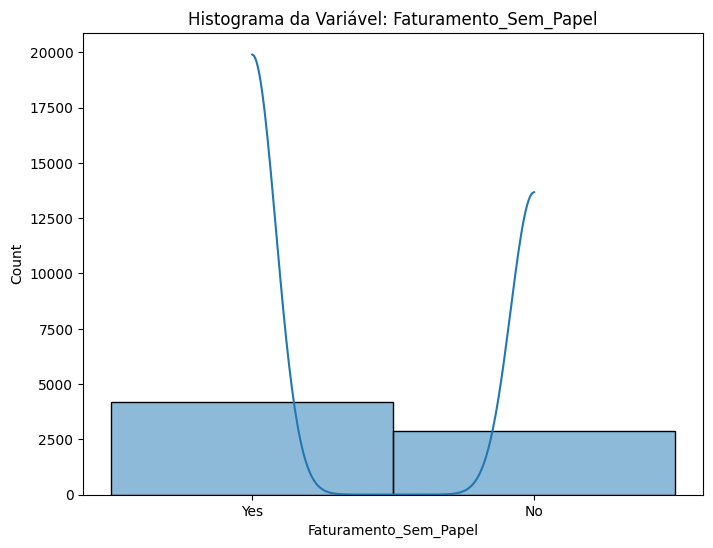

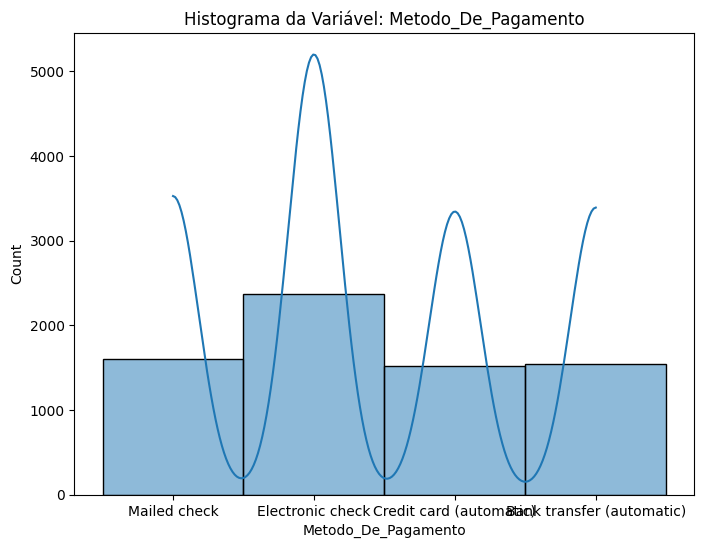

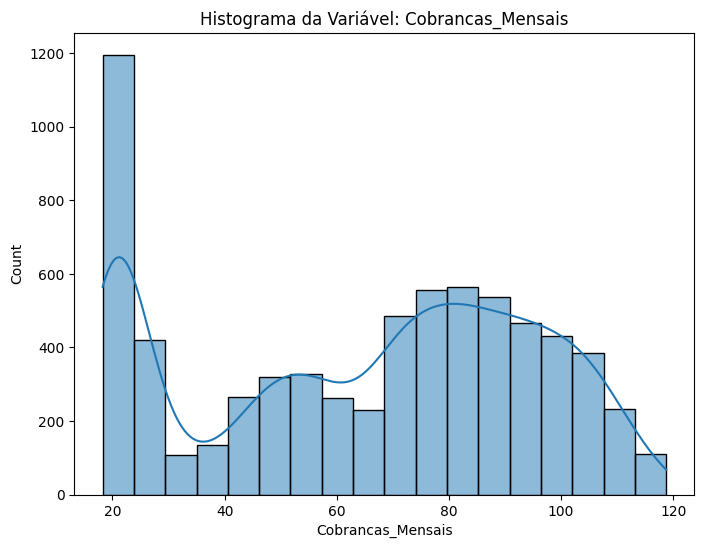

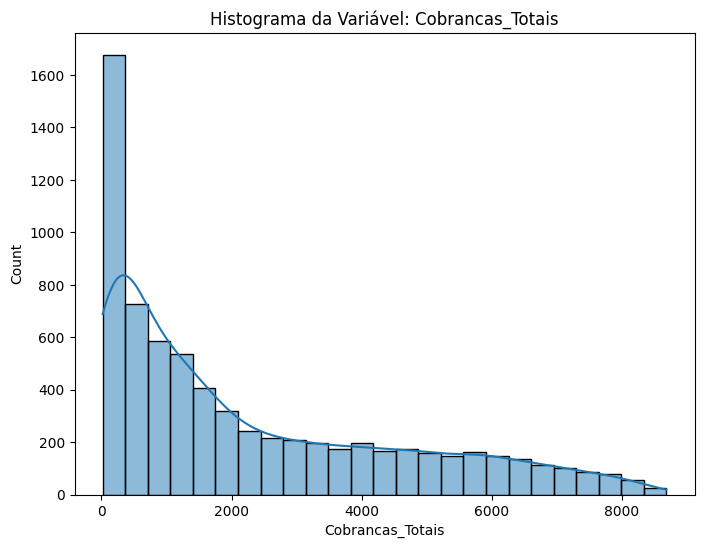

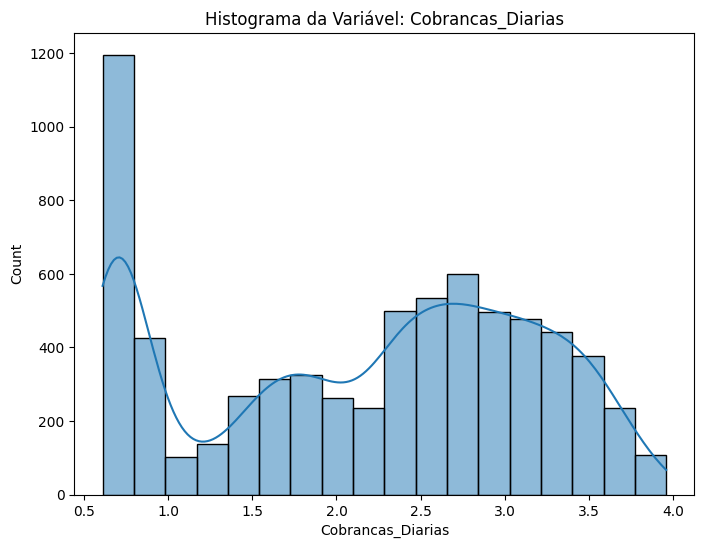

In [ ]:
for coluna in df_manipulacao.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_manipulacao, x=coluna, kde=True)
    plt.title(f'Histograma da Variável: {coluna}')
    plt.xlabel(coluna)

In [ ]:
# Distribuição das variáveis

for coluna in df_manipulacao.columns:
  fig = px.bar(df_manipulacao[coluna].value_counts(), x=df_manipulacao[coluna].value_counts().index, y=df_manipulacao[coluna].value_counts().values,
                color=df_manipulacao[coluna].value_counts().index,
                labels={'x': coluna, 'y': 'contagem'},
                title=f'Distribuição da variável: {coluna}')

  fig.update_layout(width=800, height=600)

  fig.show()  # Exibe o gráfico

In [ ]:
for coluna in df_manipulacao.columns:
  fig = px.histogram(df_manipulacao, x=coluna, color='Cancelamento', barmode='group',
                      title=f'Contagem de {coluna} por Churn',
                      labels={'x': coluna, 'y': 'Contagem'})
  fig.update_layout(width=800, height=600)
  fig.show()


# Separa em Categóricas e Numéricas

In [ ]:
df_numericas = df_manipulacao[['Tempo_De_Contrato', 'Cobrancas_Mensais', 'Cobrancas_Totais', 'Cobrancas_Diarias']]
df_categoricas = df_manipulacao.drop(columns=['Tempo_De_Contrato', 'Cobrancas_Mensais', 'Cobrancas_Totais', 'Cobrancas_Diarias'])

In [ ]:
df_numericas.head()

,Tempo_De_Contrato,Cobrancas_Mensais,Cobrancas_Totais,Cobrancas_Diarias
ID,,,,
0002-ORFBO,9,65.6,593.30,2.19
0003-MKNFE,9,59.9,542.40,2.00
0004-TLHLJ,4,73.9,280.85,2.46
0011-IGKFF,13,98.0,1237.85,3.27
0013-EXCHZ,3,83.9,267.40,2.80


In [ ]:
df_categoricas.head()

,Cancelamento,Genero,Idoso_Senior,Parceiro,Dependentes,Servico_Telefone,Varias_Linhas,Servico_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_Tv,Filmes_Streaming,Tipo_De_Contrato,Faturamento_Sem_Papel,Metodo_De_Pagamento
ID,,,,,,,,,,,,,,,,,
0002-ORFBO,No,Female,0,Yes,Yes,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check
0003-MKNFE,No,Male,0,No,No,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check
0004-TLHLJ,Yes,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check
0011-IGKFF,Yes,Male,1,Yes,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
0013-EXCHZ,Yes,Female,1,Yes,No,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check


# Fazer Codificação das Variáveis Categóricas

Como o objetivo é fazer a previsão de churn, vamos utilizar Árvores de Decisão para isso. Então não vamos ter problemas com label encoding.

In [ ]:
encoder = LabelEncoder()

for coluna in df_categoricas.columns:
    df_categoricas[coluna] = encoder.fit_transform(df_categoricas[coluna])

df_categoricas.head()

,Cancelamento,Genero,Idoso_Senior,Parceiro,Dependentes,Servico_Telefone,Varias_Linhas,Servico_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_Tv,Filmes_Streaming,Tipo_De_Contrato,Faturamento_Sem_Papel,Metodo_De_Pagamento
ID,,,,,,,,,,,,,,,,,
0002-ORFBO,0,0,0,1,1,1,0,0,0,1,0,1,1,0,1,1,3
0003-MKNFE,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,3
0004-TLHLJ,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,2
0011-IGKFF,1,1,1,1,0,1,0,1,0,1,1,0,1,1,0,1,2
0013-EXCHZ,1,0,1,1,0,1,0,1,0,0,0,1,1,0,0,1,3


In [ ]:
df_final = pd.merge(df_numericas, df_categoricas, on = 'ID', how = 'inner')
df_final.head()

,Tempo_De_Contrato,Cobrancas_Mensais,Cobrancas_Totais,Cobrancas_Diarias,Cancelamento,Genero,Idoso_Senior,Parceiro,Dependentes,Servico_Telefone,...,Servico_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_Tv,Filmes_Streaming,Tipo_De_Contrato,Faturamento_Sem_Papel,Metodo_De_Pagamento
ID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,9,65.6,593.30,2.19,0,0,0,1,1,1,...,0,0,1,0,1,1,0,1,1,3
0003-MKNFE,9,59.9,542.40,2.00,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3
0004-TLHLJ,4,73.9,280.85,2.46,1,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,2
0011-IGKFF,13,98.0,1237.85,3.27,1,1,1,1,0,1,...,1,0,1,1,0,1,1,0,1,2
0013-EXCHZ,3,83.9,267.40,2.80,1,0,1,1,0,1,...,1,0,0,0,1,1,0,0,1,3


# Data Frame Final

Agora que temos o df final e transformado, podemos focar mais nas análises dos dados em si do que na integridade e formato dos dados.

1. Relembrar as informações gerais do dataset.
2. Verificar a Distribuição das variáveis
3. Analisar outliers
4. Analisar a variável target (Churn - Cancelamento)
5. Correlação entre variáveis
6. Relação das Variáveis com a variável target.


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tempo_De_Contrato      7032 non-null   int64  
 1   Cobrancas_Mensais      7032 non-null   float64
 2   Cobrancas_Totais       7032 non-null   float64
 3   Cobrancas_Diarias      7032 non-null   float64
 4   Cancelamento           7032 non-null   int64  
 5   Genero                 7032 non-null   int64  
 6   Idoso_Senior           7032 non-null   int64  
 7   Parceiro               7032 non-null   int64  
 8   Dependentes            7032 non-null   int64  
 9   Servico_Telefone       7032 non-null   int64  
 10  Varias_Linhas          7032 non-null   int64  
 11  Servico_Internet       7032 non-null   int64  
 12  Seguranca_Online       7032 non-null   int64  
 13  Backup_Online          7032 non-null   int64  
 14  Protecao_Dispositivo   7032 non-null   int64  

In [ ]:
df_final.shape

(7032, 21)

In [ ]:
df_final.describe()

,Tempo_De_Contrato,Cobrancas_Mensais,Cobrancas_Totais,Cobrancas_Diarias,Cancelamento,Genero,Idoso_Senior,Parceiro,Dependentes,Servico_Telefone,...,Servico_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_Tv,Filmes_Streaming,Tipo_De_Contrato,Faturamento_Sem_Papel,Metodo_De_Pagamento
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,2.159891,0.265785,0.504693,0.162400,0.482509,0.298493,0.903299,...,0.872582,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.688567,0.592719,1.573237
std,24.545260,30.085974,2266.771362,1.002955,0.441782,0.500014,0.368844,0.499729,0.457629,0.295571,...,0.737271,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.832934,0.491363,1.067504
min,1.000000,18.250000,18.800000,0.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,35.587500,401.450000,1.187500,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,29.000000,70.350000,1397.475000,2.340000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,55.000000,89.862500,3794.737500,2.992500,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
max,72.000000,118.750000,8684.800000,3.960000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


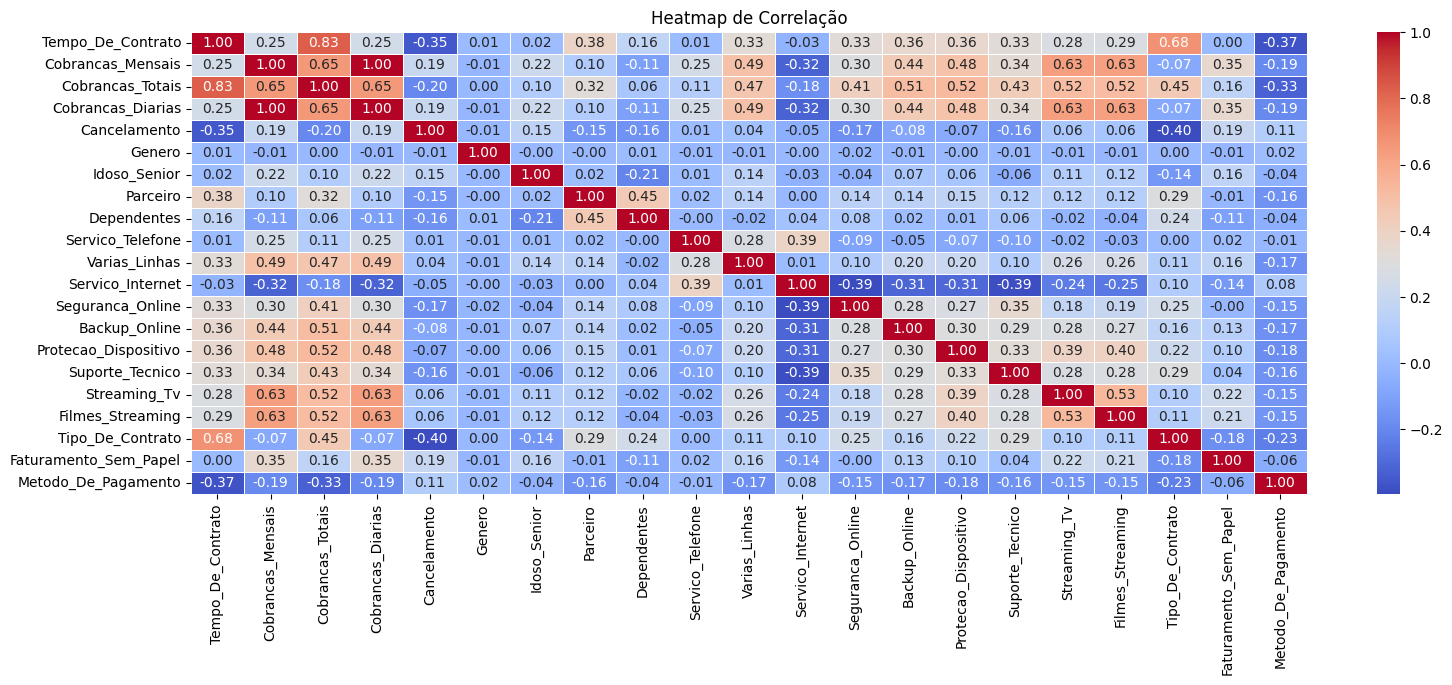

In [ ]:
correlacao = df_final.corr()
plt.figure(figsize=(18, 6))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Heatmap de Correlação")
plt.show()

# Resumo da Etapa Anterior

1. Extraímos os Dados
2. Criamos o DataFrame
3. Exploramos os dados e identificamos tamanho, variáveis, tipos de dados, valores faltantes.
4. Corrigimos os valores faltantes e removemos, ajustamos os nomes das colunas, fizemos uma investigação inicial da distribuição dos dados.
5. Investigamos melhor a distribuição dos dados e procuramos padrões entre as distribuições da variável target com as variáveis independentes.
6. Levantamos hipóteses das análises.
7. Traduzimos os nomes das colunas automaticamente utilizando API da OpenAI (para aprendizado).
8. Criamos a coluna de Cobranças Diária (desafio extra).
9. Salvamos o DF em um arquivo CSV.


# Resumo Até Agora
1. Importamos o CSV criado na etapa anterior.
2. Separamos o DF em variáveis numéricas e categóricas.
3. Fizemos Encoding das variáveis categóricas utilizando Label Encoder.
4. Unimos as variáveis numéricas com as categóricas após a codificação.
5. Puxamos as informações estatísticas e gerais do data frame para relembrar.
6. Fizemos um Heatmap de correlação entre as variáveis.

# Conclusões das Análises dos Gráficos de Distribuição


## Distribuições Desiguais:

- Temos um número muito mais alto de contagens para Não Churn que Sim Churn
- Senioridade está desigual, poucos clientes idosos.
- Dependentes está desigual
- Acúmulo de Tempo de contrato nos valores mais baixos
- PhoneService
- Online Security
- Online Backup
- Device Protection
- TechSupport
- StreamingTV
- StreamingMovies
- Acúmulo de ChargesMonthly e Total nas faixas menores, o que faz sentido pro ChargesTotal já que temos um número de clientes com poucos meses de contrato. Mas ChargesMonthly indica que temos um grande número de clientes com ticket baixo.

## Distribuições Iguais:
- A distribuiçõa de Gênero está equivalente.
- Parceiros está igual.
- Linhas Múltiplas
- InternetService
- Contract
- Paperless Billing
- Payment Method

## Hipóteses Levantadas

- Entre homens e mulheres não vemos um padrão maior de churn por gênero.
- Entre os idosos, vemos uma taxa de cancelamento muito alta.
- Clientes que não possuem parceiros tendem a cancelar em torno de 2x mais.
- Existem mais clientes sem dependentes, porém os clientes com dependentes possuem uma taxa de cancelamento significativamente menor.
- A contagem alta de Churns em clientes com poucos meses de contrato demonstra uma taxa de cancelamento alta para os primeiros meses de contratação.
- Existe um número muito superior de clientes com contratação de serviços telefônicos, porém a taxa de churn aparenta estar proporcionalmente igual.
- Temos mais clientes SEM múltiplas linhas, mas a taxa de churn para os que tem é significativamente maior.
- A taxa de cancelamento para clientes com serviço de internet por fibra ótica extremamente alta, beirando os 50%. O que indica possível problema com o tipo de serviço.
- Temos mais clientes sem segurança online e com maior taxa de cancelamento do que aqueles que TEM segurança online.
- Mais clientes sem backup online, com uma taxa de cancelamento ligeiramente menor para aqueles que possuem backup online.
- O mesmo acontece para os clientes que possuem proteção de dispositivos.
- Clientes com suporte técnico tem uma taxa de churn 2x menor.
- Clientes sem StreamingTV possuem taxa de cancelamento menor, indicando possível problema com o tipo de serviço.
- O mesmo acontece para clientes sem StreamingMovies.
- Clientes com contrato mês a mês tem um Churn muito alto, em torno de 40%.
- Clientes com faturamento digital cancelam muito mais.
- Clientes que pagam com cheque eletrônico cancelam em torno de 40%.
- Não parece haver um padrão de churn em relação ao preço mensal.
- Distribuições desiguais podem fazer ser necessário utilizar uma reamostragem dos dados para evitar enviesamento do modelo. Utilizar outras métricas além de Acurácia, como F1-score, Recall e ROC-AUC.

# Oversample

Como a distribuição das classes das variáveis não estão necessariamente iguais, precisamos realizar o oversample.

A escolha do oversample sobre undersample é feita porque o dataset não tem uma quantidade tão expressiva e, considerando a distribuição da variável target, perderíamos cerca de 33% das informações.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
X = df_final.drop(columns='Cancelamento')
y = df_final['Cancelamento']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
print("Distribuição original:", y_train.value_counts())
print("Distribuição após SMOTE:", pd.Series(y_train_res).value_counts())


Distribuição original: Cancelamento
0    4130
1    1495
Name: count, dtype: int64
Distribuição após SMOTE: Cancelamento
0    4130
1    4130
Name: count, dtype: int64


# Finalizamos a etapa de Exploração, Entendimento, Limpeza e Manipulação dos Dados.

# Criando Modelos

Vou testar 3 modelos:
- Regressão Logística
- Random Forest
- Gradient Boosting (XGBoost)

Utilizaremos Matriz de confusão para verificar falsos positivos e negativos.

Para métricas, colocaremos (em ordem de prioridade):
- Recall para validar os falsos negativos
- Acurácia balanceada, por haver desbalanceamento de classes e valorizar o acerto de cada classe, para ver um desempenho geral do modelo;
- AUC Para comparação de modelos;
- Precisão para validar o número de falsos positivos;
- F1 Score para uma avaliação balanceada entre precisão e recall.



## Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay


In [ ]:
lr = LogisticRegression(max_iter=200)

In [ ]:
lr.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=200)

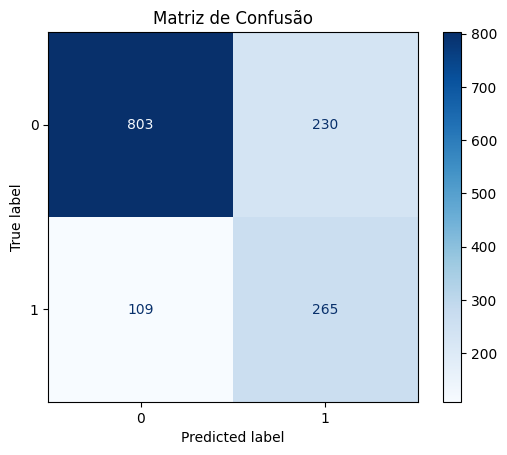

In [ ]:
lr_y_pred = lr.predict(X_test)
lr_y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Matriz de Confusão para visualizar falsos positivos e negativos
cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# Avaliação
recall_lr = recall_score(y_test, lr_y_pred)
acc_score_lr = lr.score(X_test, y_test)
acc_balanceada_lr = balanced_accuracy_score(y_test, lr_y_pred)
auc_lr = roc_auc_score(y_test, lr_y_pred_proba)
f1_lr = f1_score(y_test, lr_y_pred)
precision_lr = precision_score(y_test, lr_y_pred)


print(f"Recall: {recall_lr * 100:.2f}%")
print(f"Acurácia no teste: {acc_score_lr * 100:.2f}%")
print(f"Acurácia Balanceada: {acc_balanceada_lr * 100:.2f}%")
print(f"AUC: {auc_lr * 100:.2f}%")
print(f"Precisão: {f1_lr * 100:.2f}%")
print(f"F1 Score: {precision_lr * 100:.2f}%")


Recall: 70.86%
Acurácia no teste: 75.91%
Acurácia Balanceada: 74.30%
AUC: 81.07%
Precisão: 60.99%
F1 Score: 53.54%


# Criando modelos seguidos e um DF para comparação.

In [ ]:
# Instanciando Modelos
modelo_lr = LogisticRegression(max_iter=200)
modelo_rf = RandomForestClassifier(random_state=42)
modelo_xgb = XGBClassifier(random_state=42)

# Dicionário de Modelos
modelos = {
    'Logistic Regression': modelo_lr,
    'Random Forest': modelo_rf,
    'Gradient Boosting': modelo_xgb
}

metrics = []

# Treinamento de Modelos
for nome_modelo, modelo in modelos.items():
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    metrics.append({
        'Modelo': nome_modelo,
        'Recall': recall_score(y_test, y_pred),
        'Acurácia_Bal': balanced_accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'F1-score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred)
    })





/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Converter a lista de dicionários em um DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics

,Modelo,Recall,Acurácia_Bal,AUC,F1-score,Precision
0,Logistic Regression,0.708556,0.742952,0.810669,0.609896,0.535354
1,Random Forest,0.588235,0.704573,0.801064,0.564827,0.543210
2,Gradient Boosting,0.580214,0.702498,0.792263,0.562176,0.545226


# Tunning de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Instanciando Modelos
modelo_lr = LogisticRegression()
modelo_rf = RandomForestClassifier(random_state=42)
modelo_xgb = XGBClassifier(random_state=42)

# Dicionário de Modelos
modelos = {
    'Logistic Regression': modelo_lr,
    'Random Forest': modelo_rf,
    'Gradient Boosting': modelo_xgb
}


# Grids de Hiperparâmetros

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1],
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'max_iter': [200, 300]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1],
        'max_features': ['auto', 'sqrt']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Lista de Métricas

metrics = []

# Treinamento de Modelos
for nome_modelo, modelo in modelos.items():
  print(f"Ajustando hiperparâmetros para {nome_modelo}...")

  # Cria o GridSearchCV usando o grid correspondente
  grid = GridSearchCV(estimator=modelo,
                      param_grid=param_grids[nome_modelo],
                      cv=5,
                      scoring='recall',
                      n_jobs=-1,
                      verbose=1)
  grid.fit(X_train_res, y_train_res)

  # Obtém o melhor modelo encontrado
  melhor_modelo = grid.best_estimator_
  print(f"Melhores parâmetros para {nome_modelo}:", grid.best_params_)

  # Fazendo Predições
  y_pred = melhor_modelo.predict(X_test)
  y_pred_proba = melhor_modelo.predict_proba(X_test)[:, 1]

  # Calculando Métricas e Adicionando
  metrics.append({
      'Modelo': nome_modelo,
      'Recall': recall_score(y_test, y_pred),
      'Acurácia_Bal': balanced_accuracy_score(y_test, y_pred),
      'AUC': roc_auc_score(y_test, y_pred_proba),
      'F1-score': f1_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred)
  })





Ajustando hiperparâmetros para Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros para Logistic Regression: {'C': 0.01, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
Ajustando hiperparâmetros para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils

Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Ajustando hiperparâmetros para Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores parâmetros para Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Converter a lista de dicionários em um DataFrame
df_metrics_tunned = pd.DataFrame(metrics)
df_metrics_tunned

,Modelo,Recall,Acurácia_Bal,AUC,F1-score,Precision
0,Logistic Regression,0.775401,0.756045,0.824316,0.619658,0.516014
1,Random Forest,0.684492,0.733824,0.814717,0.599532,0.533333
2,Gradient Boosting,0.796791,0.729470,0.801749,0.583741,0.460587


# Conclusão

Os modelos foram otimizados e, com base nas métricas, Logistic Regression parece ser uma melhor opção. Ainda que o recall tenha dado um score menor, as outras métricas estão melhores e suportam a escolha pela diferença pequena no Recall.